# Zero-shot spot integration with scGPT

In [ ]:
# MIT License

# Copyright (c) 2022 Haotian Cui

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Based on code from https://github.com/bowang-lab/scGPT

## Introduction

We perform zero-shot integration of multiple Spatial Transcriptomics samples with continual pre-trained scGPT.

Continual pre-trained scGPT (scGPT_CP) is a model that inherits the pre-trained scGPT whole-human model checkpoint, and is further supervised by extra cell type labels (using the [Tabula Sapiens](https://tabula-sapiens-portal.ds.czbiohub.org/) dataset) during the continual pre-training stage. We observed that the scGPT_CP model can achieve comparable or better zero-shot performance on cell embedding related tasks compared to the original checkpoint, especially on datasets with observable technical batch effects.

We use the `scGPT_CP` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1_GROJTzXiAV8HB4imruOTk6PEGuNOcgB).

## Import scGPT and dependencies

In [26]:
from pathlib import Path
import warnings

import scanpy as sc
import scib
import numpy as np
import sys
from sklearn.metrics import adjusted_rand_score
import torch
import os

import scgpt as scg
import matplotlib.pyplot as plt

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

# Path to model weights
# Clone and follow setup instructions in scGPT repository first
model_dir = Path("../../scGPT/scGPT_CP")

gene_col = "Gene Symbol"
N_HVG = 1800

## Prepare the datasets

In [32]:
root = "../data/space_ranger_outputs/"
adata_train = sc.read_h5ad(os.path.join(root, "TENX146/gex_stride5_filt.h5ad"))
adata1 = sc.read_h5ad(os.path.join(root, "TENX45/gex_filt.h5ad"))
adata2 = sc.read_h5ad(os.path.join(root, "151/gex_filt.h5ad"))
adata3 = sc.read_h5ad(os.path.join(root, "152/gex_filt.h5ad"))
adata4 = sc.read_h5ad(os.path.join(root, "153/gex_filt.h5ad"))
adata5 = sc.read_h5ad(os.path.join(root, "154/gex_filt.h5ad"))

In [33]:
cluster_mapping_1 = {"0": "3","1": "0", "2":"1", "3":"2", "4":"4"}
cluster_mapping_2 = {"0":"0", "1": "2", "2":"1", "3":"3", "4":"4"}
cluster_mapping_3 = {"0":"1", "1": "0", "2": "2", "3": "4", "4":"3"}
cluster_mapping_4 = {"0":"4", "1": "0", "2": "2", "3": "1", "4":"3"}
cluster_mapping_5 = {"0":"1", "1": "0", "2": "2", "3": "4", "4":"3"}

In [34]:
cluster_labs = np.load(os.path.join(root, "TENX45/gene_clip_emb_45_cluster5.npy"))
adata1.obs["cluster"] = cluster_labs
adata1.obs["cluster"] = adata1.obs["cluster"].astype(str).astype("category")
adata1.obs["cluster"] = adata1.obs.cluster.cat.rename_categories(cluster_mapping_1)
cluster_labs = np.load(os.path.join(root, "151/gene_clip_emb_151_cluster5.npy"))
adata2.obs["cluster"] = cluster_labs
adata2.obs["cluster"] = adata2.obs["cluster"].astype(str).astype("category")
adata2.obs["cluster"] = adata2.obs.cluster.cat.rename_categories(cluster_mapping_2)
cluster_labs = np.load(os.path.join(root, "152/gene_clip_emb_152_cluster5.npy"))
adata3.obs["cluster"] = cluster_labs
adata3.obs["cluster"] = adata3.obs["cluster"].astype(str).astype("category")
adata3.obs["cluster"] = adata3.obs.cluster.cat.rename_categories(cluster_mapping_3)
cluster_labs = np.load(os.path.join(root, "153/gene_clip_emb_153_cluster5.npy"))
adata4.obs["cluster"] = cluster_labs
adata4.obs["cluster"] = adata4.obs["cluster"].astype(str).astype("category")
adata4.obs["cluster"] = adata4.obs.cluster.cat.rename_categories(cluster_mapping_4)
cluster_labs = np.load(os.path.join(root, "154/gene_clip_emb_154_cluster5.npy"))
adata5.obs["cluster"] = cluster_labs
adata5.obs["cluster"] = adata5.obs["cluster"].astype(str).astype("category")
adata5.obs["cluster"] = adata5.obs.cluster.cat.rename_categories(cluster_mapping_5)

In [35]:
def preproc(adata):
    adata.var_names = [x.upper() for x in adata.var_names]
    adata.var[gene_col] = list(adata.var_names)
    adata.X = adata.X.toarray()

def standardize(a, batch_key = None, highly_variable = True):
    sc.pp.normalize_total(a, target_sum=1e4)
    sc.pp.log1p(a)
    if highly_variable:
        # highly variable genes
        sc.pp.highly_variable_genes(a, n_top_genes=N_HVG, flavor='seurat_v3', subset=True, batch_key=batch_key)

In [36]:
for a in [adata1, adata2, adata3, adata4, adata5, adata_train]:
    preproc(a)

In [37]:
adata_j = adata1.concatenate(adata2, adata3, adata4, adata5, adata_train, batch_categories=["sample 1", "sample 2", "sample 3", "sample 4", "sample 5", "train sample"])
standardize(adata_j, batch_key="batch", highly_variable=True)

/tmp/ipykernel_700048/2120163464.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_j = adata1.concatenate(adata2, adata3, adata4, adata5, adata_train, batch_categories=["sample 1", "sample 2", "sample 3", "sample 4", "sample 5", "train sample"])
/scratch/site/u/lohmanf1/conda/envs/scgpt/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Generate the spot embeddings

The extracted embedding is stored in the `X_scGPT` field of `obsm` in AnnData.

In [38]:
torch.manual_seed(1)
embed_adata = scg.tasks.embed_data(
    adata_j,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1469/1800 genes in vocabulary of size 60697.


/scratch/site/u/lohmanf1/conda/envs/scgpt/lib/python3.10/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 4951/4951 [04:52<00:00, 16.92it/s]
/scratch/site/u/lohmanf1/conda/envs/scgpt/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

In [39]:
# remove training data
embed_adata = embed_adata[embed_adata.obs.batch != "train sample"]

In [ ]:
np.save("../data/embeddings/scGPT_hvg1800_emb_sample1-5.npy", embed_adata.obsm["X_scGPT"], allow_pickle=False)

In [40]:
embed_adata.obs.cluster = embed_adata.obs.cluster.cat.reorder_categories(["0", "1", "2", "3", "4"])
embed_adata.obsm["X_scGPT"] = sc.pp.pca(embed_adata.obsm["X_scGPT"], n_comps=50, random_state=0)

/scratch/site/u/lohmanf1/conda/envs/scgpt/lib/python3.10/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [41]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT", random_state=0)
sc.tl.umap(embed_adata, random_state=0)
sc.tl.leiden(embed_adata, n_iterations=2, flavor="igraph", key_added="clusters_joint", resolution=0.1, random_state=0) # resolution 0.35 when using all genes

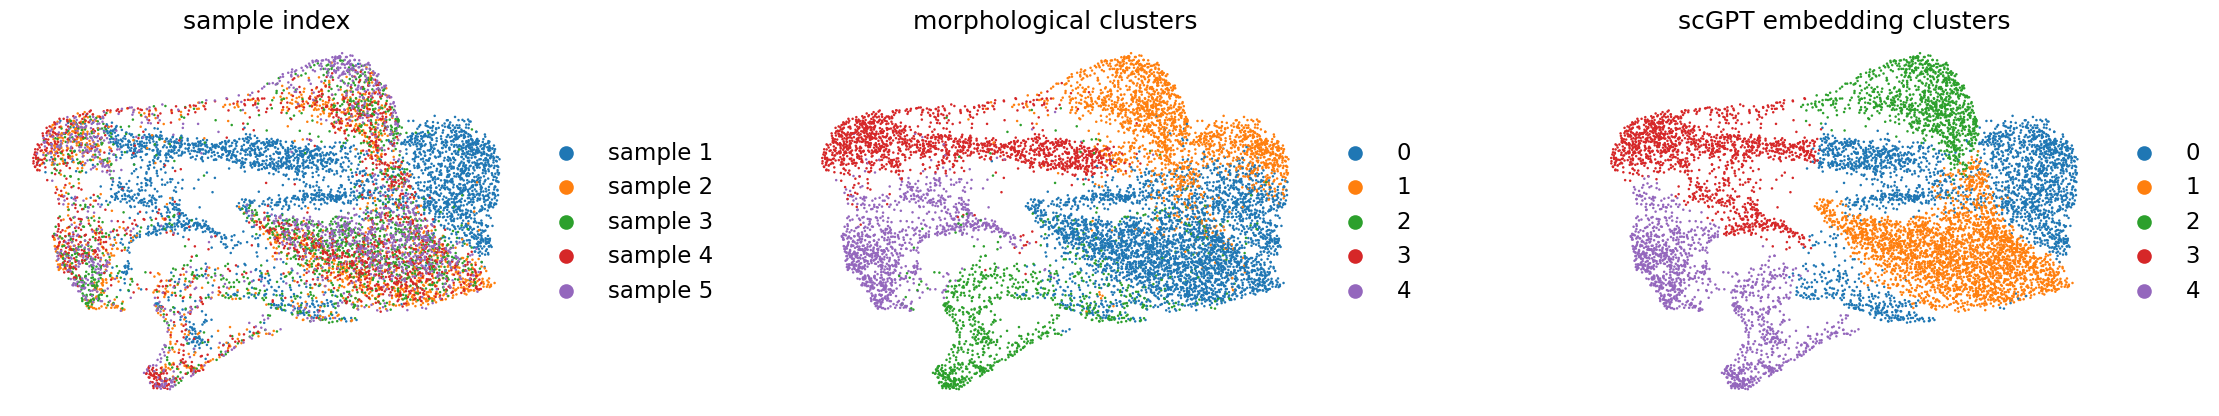

In [42]:
sc.pl.umap(embed_adata, 
           color=["batch", "cluster", "clusters_joint"],
           frameon=False, 
           wspace=0.4,
           title = ["sample index", "morphological clusters", "scGPT embedding clusters"]
        )

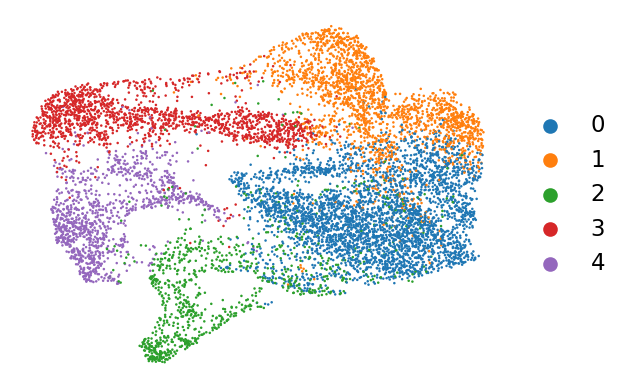

In [43]:
sc.pl.umap(embed_adata, 
           color=["cluster"],
           frameon=False, 
           wspace=0.4,
           title = [None]
        )

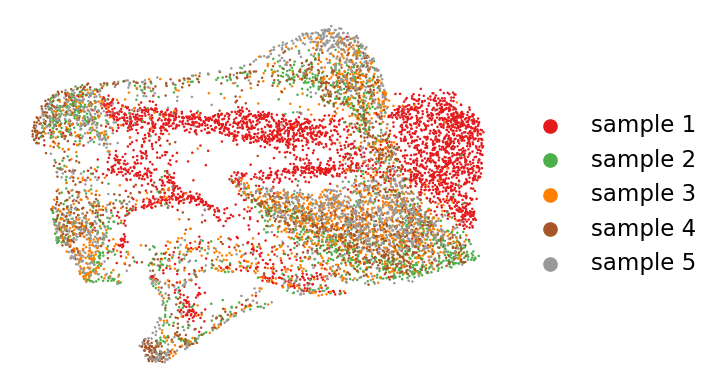

In [44]:
sc.pl.umap(embed_adata, 
           color=["batch"],
           frameon=False, 
           wspace=0.4,
           palette="Set1",
           title = [None]
        )

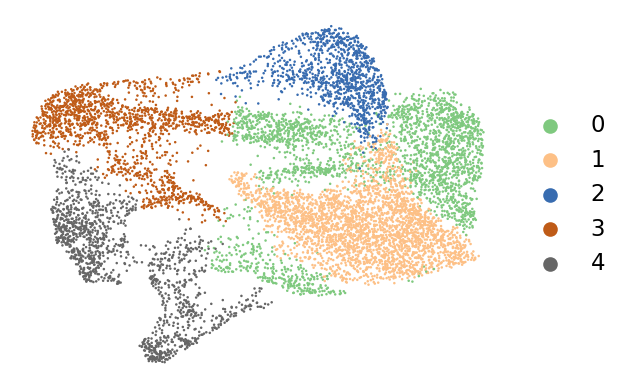

In [45]:
sc.pl.umap(embed_adata, 
           color=["clusters_joint"],
           frameon=False, 
           wspace=0.4,
           palette="Accent",
           title = [None]
        )

In [47]:

print("ARI morphological clusters vs. scGPT embedding clusters =", adjusted_rand_score(embed_adata.obs.clusters_joint.values, embed_adata.obs.cluster.values))
print("ARI sample index vs. scGPT embedding clusters =", adjusted_rand_score(embed_adata.obs.clusters_joint.values, embed_adata.obs.batch))

ARI morphological clusters vs. scGPT embedding clusters = 0.43333184656433515
ARI sample index vs. scGPT embedding clusters = 0.2549671800753462
